In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! pip install chart_studio

     |████████████████████████████████| 64 kB 1.7 MB/s 


In [3]:
import pandas as pd
import itertools
import spacy
from tqdm.notebook import tqdm_notebook
from tqdm import  tqdm
tqdm_notebook.pandas(desc="progress bar")
import numpy as np
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go

In [4]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

pd.set_option('display.max_colwidth', None)

In [5]:
pd.reset_option('all')


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/usr/local/lib/python3.7/dist-packages/pandas/_config/config.py:622: FutureWarning:


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.




In [6]:
# Consider: applying heuristics on sentence level - because if we wanna include a useful thing e.g. materials...purchasing, we wanna restrict to only within the sentence
# Therefore, create a method to split at sentence level, then run the rules.
import re
import itertools
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas(desc="progress bar")

gic_heuristic_id = '330.2'
gic_topic_desc = 'diversity'

#### UPDATE ME!!! SET UP HEURISTICS ###

any_valid_chars = '([A-Za-z\d%,;\'\\\"\s])*'
diversity_context = '(\sdiverse\s|\sdiversity\s|inclusion|inclusive)'
relevant_context = '(women|female|minorities|\scolor\s|enthnicities|\srace\s|\sracism\s|racial|\ssexual\sorient|gender|disabili|military.+veteran|veteran.+military|protected.+veteran|veteran.+protected|veteran status)' 
# worker_context = '(worker\s|workforce|outreach|training)'
worker_context = '(worker\s|workforce|outreach|training|director|)'

terms_to_include = [any_valid_chars+diversity_context+any_valid_chars\
                    +relevant_context+any_valid_chars, any_valid_chars+relevant_context+any_valid_chars\
                    +diversity_context+any_valid_chars, any_valid_chars+diversity_context+any_valid_chars\
                    +worker_context+any_valid_chars, any_valid_chars+worker_context+any_valid_chars\
                    +diversity_context+any_valid_chars]

# terms_to_include = [any_valid_chars+diversity_context+any_valid_chars\
#                     +relevant_context+any_valid_chars+worker_context+any_valid_chars,
#                     any_valid_chars+diversity_context+any_valid_chars\
#                     +worker_context+any_valid_chars+relevant_context+any_valid_chars,
#                     any_valid_chars+relevant_context+any_valid_chars\
#                     +worker_context+any_valid_chars+diversity_context+any_valid_chars,
#                     any_valid_chars+relevant_context+any_valid_chars\
#                     +diversity_context+any_valid_chars+worker_context+any_valid_chars,
#                     any_valid_chars+worker_context+any_valid_chars\
#                     +relevant_context+any_valid_chars+diversity_context+any_valid_chars,
#                     any_valid_chars+worker_context+any_valid_chars\
#                     +diversity_context+any_valid_chars+relevant_context+any_valid_chars]


terms_to_exclude = ['diverse client', 'diverse customer', 'energy diversity', 'dna', 'rna', 'diverse client', 'diverse customer','divers.+investmen', 'investmen.+divers',
                    'diverse skills', 'footwear', 'shoes', 'clinical', 'decor', 'diverse skills', 'diverse need']

heuristics = [
              # PASS #1
              {'include': terms_to_include,
               'exclude':terms_to_exclude}       
              ]

# set up apply_heuristics method
def apply_heuristics(text, terms_to_include, terms_to_exclude):

  # lowercase text
  text = text.lower()

  # replace line breaks
  text = text.replace('\n', ' ')

  terms_to_include = terms_to_include[0] if len(terms_to_include) == 1 else '|'.join(terms_to_include)
  terms_to_exclude = terms_to_exclude[0] if len(terms_to_exclude) == 1 else '|'.join(terms_to_exclude)

  if (len(terms_to_include) == 0 or re.search(terms_to_include, text)) \
      and (len(terms_to_exclude) == 0 or (not re.search(terms_to_exclude, text))):
      return 1
  else:
    return 0

# set up dataframe to store results
# Training Data

# df_result.to_csv('/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_1.0 hypothesis testing/10ks_sics_gic_'+gic+'_'+gic_topic_desc+'_full.csv', index=False)
# df_result[['id', 'ticker_display', 'primary_industry_id', 'text']].sample(100).to_csv('/content/drive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_1.0 hypothesis testing/10ks_sics_gic_'+gic+'_'+gic_topic_desc+'_sample.csv', index=False)

In [7]:
from google.colab import auth
auth.authenticate_user()

project_id = 'dfg-cohrv-314114'

In [8]:
import pandas as pd
# https://cloud.google.com/resource-manager/docs/creating-managing-projects

##### UPDATE ME! #####
GIC_HEURISTIC_ID = '330.2' 

# don't worry about case sensitivity. it is taken care of in the SQL statement
terms_to_include = heuristics[0]['include']
terms_to_exclude = heuristics[0]['exclude']

# combine terms to include into a regex statement
if len(terms_to_include) > 0:
  terms_to_include = terms_to_include[0] if len(terms_to_include) == 1 else '|'.join(terms_to_include)
else:
  terms_to_include = '~'

# combine terms to exclude into a regex statement
if len(terms_to_exclude) > 0:  
  terms_to_exclude = terms_to_exclude[0] if len(terms_to_exclude) == 1 else '|'.join(terms_to_exclude)
else:
  terms_to_exclude = '~'

# retrieve positive results
df_result_pos = pd.io.gbq.read_gbq(
  '''
  SELECT *
  FROM `dfg_cohrv.10ks_para_sics`
  WHERE 
    REGEXP_CONTAINS(text, r"(?i)('''+terms_to_include+''')") 
    AND NOT REGEXP_CONTAINS(text, r"(?i)('''+terms_to_exclude+''')")
  '''
, project_id=project_id)

# retrieve negative results
df_result_neg = pd.io.gbq.read_gbq(
  '''
  WITH t AS
  (
    SELECT *
    FROM `dfg_cohrv.10ks_para_sics`
    WHERE 
      REGEXP_CONTAINS(text, r"(?i)('''+terms_to_include+''')") 
      AND REGEXP_CONTAINS(text, r"(?i)('''+terms_to_exclude+''')")
  )
  SELECT * FROM t
  WHERE RAND() < 100/(SELECT COUNT(*) FROM t)  
  '''
, project_id=project_id)

df_result_pos['gic_heuristic_id'] = GIC_HEURISTIC_ID
df_result_neg['gic_heuristic_id'] = GIC_HEURISTIC_ID

df_result_pos = df_result_pos[['gic_heuristic_id', 'id', 'ticker_display', 'primary_industry_id', 'text']]
df_result_neg = df_result_neg[['gic_heuristic_id', 'id', 'ticker_display', 'primary_industry_id', 'text']]

In [9]:
#Specific to Supply Chains
df_result = pd.DataFrame()
df_tmp = df_result_pos.copy()
for h in heuristics[1:]:
  df_tmp['result'] = df_tmp['text'].progress_apply(lambda x: \
                        apply_heuristics(x, h['include'], h['exclude']))
  df_tmp = df_tmp[df_tmp['result'] == 1]
df_result = pd.concat((df_result, df_tmp))

In [10]:
pd.set_option('display.max_colwidth', None)

In [11]:
df_10ks_sics = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/usable_10ks_with_sics.csv')
df_10ks_sics['year'] = df_10ks_sics['fy'].astype('str').str[:4]

In [12]:
# calculate and join industry-level ticker counts
df_ind_total = df_10ks_sics.groupby(['year', 'primary_industry_id'])\
                .agg({'ticker_display': pd.Series.nunique}).reset_index()
df_ind_total.columns = ['year', 'primary_industry_id', 'ind_tot_tkr']
df_ind_total  # dataframe that contains industries aggregated by year with the total occurances of the terms in the heuristics

,year,primary_industry_id,ind_tot_tkr
0,2000,CG-MR,1
1,2001,CG-MR,1
2,2001,TC-HW,1
3,2002,CG-MR,1
4,2002,TC-TL,1
...,...,...,...
757,2021,TC-HW,2
758,2021,TC-SC,7
759,2021,TC-SI,31
760,2021,TC-TL,1


In [13]:
GIC_HEURISTIC_ID = '330.2'
MIN_FISCAL_YEAR = '2013'
MAX_FISCAL_YEAR = '2020'

# include additional columns
df_result[['yr_qtr', 'ticker', 'type', 'fye', 'doc_id', 'p_id']] = df_result['id'].str.split('_', expand=True)
df_result['sector'] = df_result['primary_industry_id'].str[:2]
df_result['year'] = df_result['fye'].str[:4]

# keep 2013-2020 fiscal year data
df_result = df_result[(df_result['year'] >= MIN_FISCAL_YEAR) & (df_result['year'] <= MAX_FISCAL_YEAR)]

In [14]:
# df_num_paras stores the document with the number of paragraphs in it
df_num_paras = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_1.0 hypothesis testing/10ks_para_sics_tot_para.csv')
df_num_paras.shape

(35147, 2)

In [15]:
# load and join number of paragraphs by doc_id
df_result = pd.merge(left=df_result, right=df_num_paras, on='doc_id')

In [16]:
# load and join industry descriptions
df_ind_desc = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/sasb_label_20210128/industry.csv')
df_ind_desc = df_ind_desc[['INDUSTRY_ID', 'INDUSTRY_NAME']]
df_ind_desc.columns = ['primary_industry_id', 'primary_industry_desc']

In [17]:
# replace the names with short names
df_ind_desc = df_ind_desc.replace("Electric Utilities & Power Generators", "Elec Utils & Power Gen")
df_ind_desc = df_ind_desc.replace("Electronic Manufacturing Services & Original Design Manufacturing", "Elec Manuf Svcs & Orig Des Manuf")
df_ind_desc = df_ind_desc.replace("Engineering & Construction Services", "Engg & Construction Svcs")
df_ind_desc = df_ind_desc.replace("Oil & Gas – Exploration & Production", "Oil & Gas – Expl & Prod")
df_ind_desc = df_ind_desc.replace("Professional & Commercial Services", "Prof & Comm Svcs")
df_ind_desc = df_ind_desc.replace("Wind Technology & Project Developers", "Wind Tech & Proj Dev")
df_ind_desc = df_ind_desc.replace("Multiline and Specialty Retailers & Distributors", "Multiline and Splty Rtl & Dists")
df_ind_desc = df_ind_desc.replace("Solar Technology & Project Developers", "Solar Tech & Proj Dev")


In [39]:
#@title Industries in the Alcoholic Beverages sector, 2020
# getting the industries in the Alcoholic Beverages sector
df_X = df_result
df_X = pd.merge(left=df_X, right=df_ind_desc, on='primary_industry_id')
bm_inds = ['CG-EC','CG-MR','FN-AC','FN-IB','SV-AD','SV-PS','TC-HW','TC-IM','TC-SI']
df_X = df_X[["year", "primary_industry_id","ticker", "ticker_display","primary_industry_desc", "doc_id", "p_id", "text"]]
df_X['year'] = df_X['year'].astype('str') 
df_X['primary_industry_desc'] = df_X['primary_industry_desc'].astype('str') 
df_filter = df_X[(df_X["primary_industry_desc"] == "Alcoholic Beverages") & (df_X["year"] == "2020")]
df_filter = df_filter[["doc_id", "ticker_display"]]
df_filter = df_filter.drop_duplicates()
df_filter

,doc_id,ticker_display
219,0000024545-21-000004.txt,TAP


# **Getting all the paragraphs that contain diversity terms for every company, by year**

In [18]:
# import sics company name - ticker csv
df_ticker = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/sasb_label_20210128/sics_2021_03_01_US_ONLY.csv', usecols=["company_ticker", "company_name"])

In [42]:
# df_ticker.columns
df_ticker[df_ticker["company_ticker"] == "TAP"]

,company_ticker,company_name
6562,TAP,Molson Coors Brewing Company


In [22]:
df_paras = df_result[["year", "ticker_display", "primary_industry_id", "text", "ticker", "doc_id", "p_id"]]
df_paras = pd.merge(left=df_paras, right=df_ind_desc, on='primary_industry_id')
df_paras = df_paras.merge(df_ticker, left_on='ticker_display', right_on='company_ticker')
df_paras = df_paras.drop(columns=["ticker_display", "company_ticker", "primary_industry_id", "ticker"])
df_paras = df_paras.drop_duplicates(subset=["year","text","doc_id"])

In [43]:
df_paras[(df_paras["company_name"] == "Molson Coors Brewing Company") & (df_paras["year"] == "2020")]

,year,company_name,primary_industry_desc,text,count
203,2020,Molson Coors Brewing Company,Alcoholic Beverages,The Company strives to be a provider of meaningful experiences for its employees and a safe and healthy workplace for all employees. We believe that building a strong and diverse workforce is a significant contributor to our success as a business and to deliver on our purpose and that we value and respect our differences. We believe that diversity with inclusion is the key to collaboration and a winning team culture. A significant component of the revitalization plan announced in October 2019 was the launch of a refreshed purpose (uniting people to celebrate all life's moments) ambition (first choice for our people consumers and customers) and shared company values (the first of which is Putting People First) all designed with a purpose of shifting the culture of the organization to drive stronger employee engagement and business engagement.,3
204,2020,Molson Coors Brewing Company,Alcoholic Beverages,With the overarching goals described in the preceding paragraph as guides the leadership team and the chief people and diversity officers for the North America and Europe business units are tasked with managing all employment-related matters including recruitment retention leadership and development compensation planning succession planning performance management and diversity and inclusion. The Compensation Human Resource Committee of the Board of Directors is responsible for establishing and reviewing the overall compensation philosophy of the Company and providing oversight on certain human capital matters including the Company's talent retention and development leadership development talent pipeline programs and systems for performance management and diversity and inclusion initiatives. The Audit Committee oversees the Company's risk management program to identify and mitigate potential risks including human capital issues. The Board of Directors then receives regular reports and recommendations from management and the board committees to help guide the Company's strategy on retaining and developing a diverse and talented workforce.,3
205,2020,Molson Coors Brewing Company,Alcoholic Beverages,In North America we promote and maintain employee resource groups for a number of different communities in our employee population - by race/ethnicity by gender LGBTQ+ early professionals young families and veterans amongst others. We encourage participation in these groups as we believe it provides an open forum for individual employees who may share similar concerns or experiences. We also promote and emphasize leadership and development opportunities for our employees which includes our First Choice Learning Center in-person and online training programs and experiential training opportunities to encourage and promote employee health and safety assist in building core competencies learning best practices and developing leadership capabilities. As we work to a more diverse workforce and management team the Company has developed programs to encourage the recruitment retention and training of diverse leaders and working to ensure we have a highly skilled and diverse workforce. We track and monitor our progress on metrics of gender and race particularly in the U.S. though data on race is not tracked in all jurisdictions.,3


In [24]:
# df_paras_count = df_paras.groupby
df_paras_count = df_paras.groupby(["doc_id"])['p_id'].size().reset_index(name='count')
df_paras = df_paras.merge(df_paras_count, left_on='doc_id', right_on='doc_id')
df_paras = df_paras.drop(columns=["doc_id", "p_id"])
df_paras = df_paras.sort_values(["year", "company_name"])
df_paras = df_paras[["year", "company_name", "primary_industry_desc", "text", "count"]]
df_paras.to_csv('positive_paras.csv')

# **TABLE C**

In [25]:
temp_C = df_result
temp_C = pd.merge(left=temp_C, right=df_ind_desc, on='primary_industry_id')
bm_inds = ['CG-EC','CG-MR','FN-AC','FN-IB','SV-AD','SV-PS','TC-HW','TC-IM','TC-SI']
temp_C = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id", "p_id", "text"]]
temp_C = temp_C.drop_duplicates(["year", "doc_id","text"])

In [ ]:
temp_C[(temp_C["year"]=="2020")]

In [27]:
trial_C1 = temp_C[["year", "primary_industry_id","primary_industry_desc", "p_id"]]
trial_C2 = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id"]]
trial_C2 = trial_C2.drop_duplicates()

trial_C1 = trial_C1.groupby(["year","primary_industry_id","primary_industry_desc"])['p_id'].size().reset_index(name='count')
trial_C1 = trial_C1.rename(columns={"year" : "Year", "primary_industry_desc" : "Primary Industry", "count":"Total paras that mention diversity"})
trial_C2 = trial_C2.groupby(["year","primary_industry_id","primary_industry_desc"])['doc_id'].size().reset_index(name='count')
trial_C2 = trial_C2.rename(columns={"year" : "Year", "primary_industry_desc" : "Primary Industry", "count":"Total 10ks that mention diversity"})

In [28]:
trial_C2[trial_C2['Primary Industry']=="Waste Management"]

,Year,primary_industry_id,Primary Industry,Total 10ks that mention diversity
86,2015,IF-WM,Waste Management,1
124,2016,IF-WM,Waste Management,1
163,2017,IF-WM,Waste Management,1
210,2018,IF-WM,Waste Management,2
256,2019,IF-WM,Waste Management,1
315,2020,IF-WM,Waste Management,7


In [29]:
all_years_table_C = pd.merge(trial_C2, trial_C1,  how='left', left_on=['Year','primary_industry_id','Primary Industry'], right_on = ['Year','primary_industry_id','Primary Industry'])


In [38]:
all_years_table_C[all_years_table_C["Primary Industry"] == "Alcoholic Beverages"]

,Year,Primary Industry,In Benchmark?,Total 10ks that mention diversity,Total paras that mention diversity
289,2020,Alcoholic Beverages,No,1,3
0,2013,Alcoholic Beverages,No,1,0
0,2014,Alcoholic Beverages,No,1,0
0,2015,Alcoholic Beverages,No,1,0
0,2016,Alcoholic Beverages,No,1,0
0,2017,Alcoholic Beverages,No,1,0
0,2018,Alcoholic Beverages,No,1,0
0,2019,Alcoholic Beverages,No,1,0


In [31]:
df_zero_industries = pd.DataFrame(columns=all_years_table_C.columns)

for i in range(2013,2021,1):
  cond = (all_years_table_C['Year']==str(i))
  inds = all_years_table_C[cond].primary_industry_id
  list_inds = set(df_ind_desc["primary_industry_id"]) - set(inds)
  list_inds = list(list_inds)
  # print("list_inds ", list_inds)

  for ind in list_inds:
    year, primary_industry_id, primary_industry_desc = str(i), ind, df_ind_desc.loc[df_ind_desc['primary_industry_id'] == ind, 'primary_industry_desc'].iloc[0]
    df_x = pd.DataFrame([[year, primary_industry_desc, 1, 0]], columns=['Year', 'Primary Industry','Total 10ks that mention diversity','Total paras that mention diversity'])
    df_zero_industries = df_zero_industries.append(df_x)


In [32]:
all_years_table_C = pd.concat([all_years_table_C,df_zero_industries], axis=0)
all_years_table_C['In Benchmark?'] = all_years_table_C['primary_industry_id']\
  .apply(lambda x: 'Yes' if x in bm_inds else 'No')
all_years_table_C = all_years_table_C[['Year','primary_industry_id','Primary Industry', 'In Benchmark?', 'Total 10ks that mention diversity', 'Total paras that mention diversity']]

In [33]:
# convert object to str
all_years_table_C["Primary Industry"] = all_years_table_C["Primary Industry"].astype(str)

In [34]:
all_years_table_C = all_years_table_C.drop(columns=['primary_industry_id'])

In [35]:
#@title table C splitting and BM
tab_C_dict = {}

for y in range(2013,2021):
  tab_C = all_years_table_C[all_years_table_C["Year"]==str(y)]
  bm = tab_C.groupby(["In Benchmark?"]).sum().loc["Yes"]
  tab_C = tab_C.append(pd.Series([str(y), "Benchmark Industries", "Yes", bm[2], bm[3]], index=all_years_table_C.columns[:5]), ignore_index=True)
  tab_C["Share"] = tab_C["Total paras that mention diversity"]/tab_C["Total 10ks that mention diversity"]  
  tab_C['Share'] = tab_C['Share'].apply(lambda x: round(x, 2))
  tab_C = tab_C.sort_values(["Share"], ascending=False)
  tab_C = tab_C.rename(columns={"Primary Industry":"Industry name", "Share" : "Average paras per 10k"})
  
  tab_C.index = np.arange(1, len(tab_C) + 1)
  tab_C_dict[str(y)] = tab_C
  tab_C.to_csv("tab_C_"+str(y)+ ".csv")


In [36]:
table_C_all_years = pd.DataFrame()
for key in tab_C_dict:
  table_C_all_years = table_C_all_years.append(tab_C_dict[key])

table_C_all_years.to_csv("table_C_all_years.csv")

**Bar chart for 2020, for intensity of diversity mentions in industries**

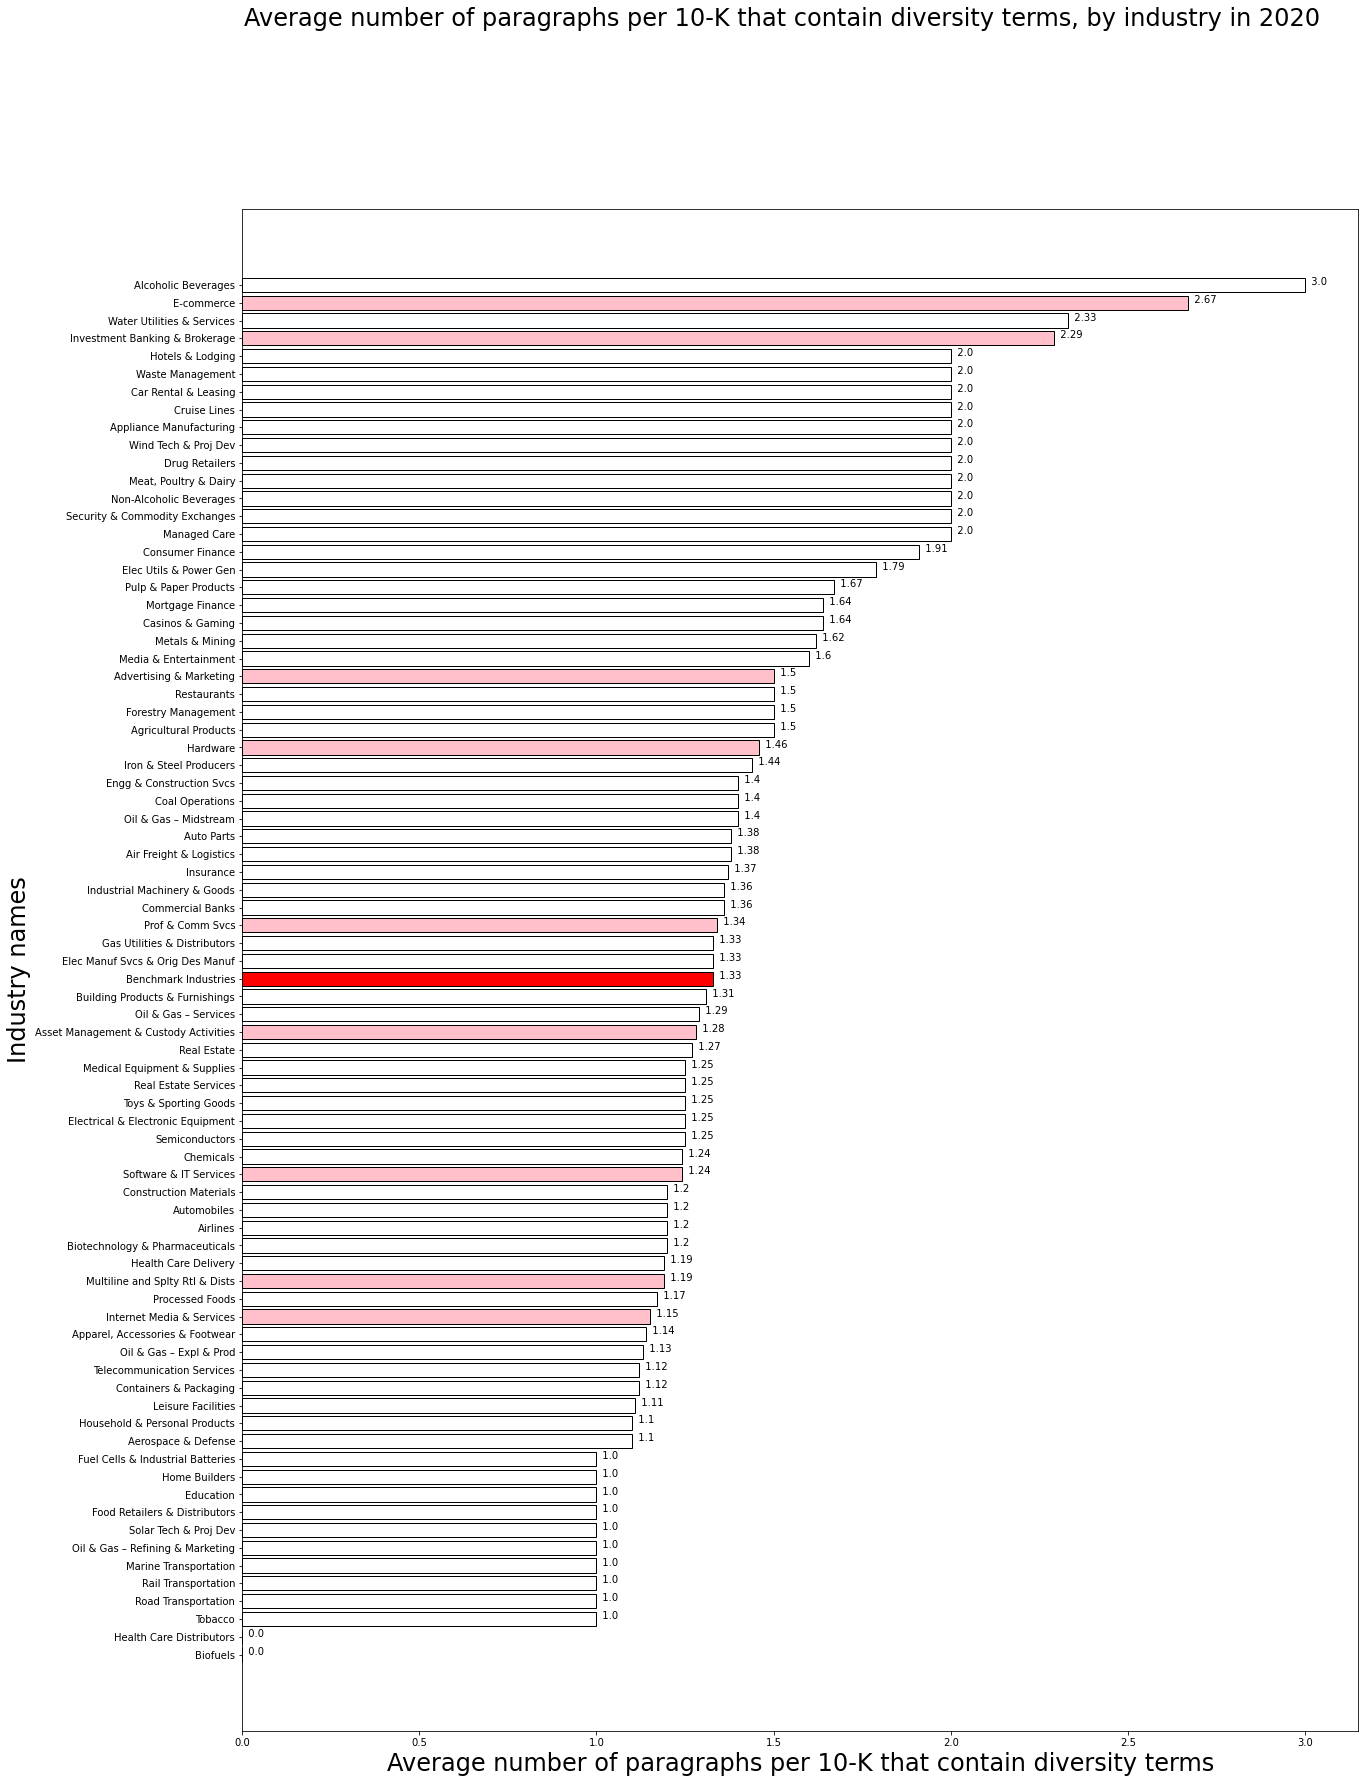

In [37]:
import matplotlib.pyplot as plt
sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Average paras per 10k"]].sort_values(by = ["Average paras per 10k"])
# sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Average paras per 10k"]] #.sort_values(by = ["Average paras per 10k"])
plt.figure(figsize=(20,28))

clrs = []
for x,y in zip(sub["Industry name"], sub["In Benchmark?"]):
	if y == 'Yes':
		if x=='Benchmark Industries':
			clrs.append('red')
   
		else:
			clrs.append('pink')
	else:
		clrs.append('white')
    
plt.barh(sub["Industry name"],sub["Average paras per 10k"], color=clrs, edgecolor='black')

for index, value in enumerate(sub["Average paras per 10k"]):
    plt.text(value, index, '  '+str(value))

plt.suptitle('Average number of paragraphs per 10-K that contain diversity terms, by industry in 2020', fontsize=24)
plt.xlabel('Average number of paragraphs per 10-K that contain diversity terms', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('diversity_paras_2020.png')


# **TABLE C MEDIAN STATISTIC**

In [ ]:
temp_C = df_result
temp_C = pd.merge(left=temp_C, right=df_ind_desc, on='primary_industry_id')
bm_inds = ['CG-EC','CG-MR','FN-AC','FN-IB','SV-AD','SV-PS','TC-HW','TC-IM','TC-SI']
temp_C = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id", "p_id"]]

In [ ]:
trial_C1 = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id","p_id"]]
trial_C1 = trial_C1.groupby(["year","primary_industry_id","primary_industry_desc", "doc_id"])['p_id'].size().reset_index(name='count')
trial_C1 = trial_C1.rename(columns={"year" : "Year", "primary_industry_desc" : "Primary Industry", "count":"Total paras that mention diversity"})


In [ ]:
# drop doc_id from trial_C1
trial_C1 = trial_C1.drop(columns=["doc_id"])

In [ ]:
trial_C1["Primary Industry"] = trial_C1["Primary Industry"].astype(str)
trial_C1["Year"] = trial_C1["Year"].astype(str)

In [ ]:
trial_C1 = trial_C1.groupby(["Year","primary_industry_id","Primary Industry"])['Total paras that mention diversity'].median().reset_index(name='median paras')

In [ ]:
trial_C2 = temp_C[["year", "primary_industry_id","primary_industry_desc", "doc_id"]]
trial_C2 = trial_C2.drop_duplicates()
trial_C2 = trial_C2.groupby(["year","primary_industry_id","primary_industry_desc"])['doc_id'].size().reset_index(name='count')
trial_C2 = trial_C2.rename(columns={"year" : "Year", "primary_industry_desc" : "Primary Industry", "count":"Total 10ks that mention diversity"})

In [ ]:
all_years_table_C = pd.merge(trial_C2, trial_C1,  how='left', left_on=['Year','primary_industry_id','Primary Industry'], right_on = ['Year','primary_industry_id','Primary Industry'])

In [ ]:
df_zero_industries = pd.DataFrame(columns=all_years_table_C.columns)

for i in range(2013,2021,1):
  cond = (all_years_table_C['Year']==str(i))
  inds = all_years_table_C[cond].primary_industry_id
  list_inds = set(df_ind_desc["primary_industry_id"]) - set(inds)
  list_inds = list(list_inds)
  # print("list_inds ", list_inds)

  for ind in list_inds:
    year, primary_industry_id, primary_industry_desc = str(i), ind, df_ind_desc.loc[df_ind_desc['primary_industry_id'] == ind, 'primary_industry_desc'].iloc[0]
    df_x = pd.DataFrame([[year, primary_industry_desc, 1, 0]], columns=['Year', 'Primary Industry','Total 10ks that mention diversity','median paras'])
    df_zero_industries = df_zero_industries.append(df_x)

# all_years_table_C = pd.concat([all_years_table_C,df_zero_industries], axis=0)

In [ ]:
all_years_table_C = pd.concat([all_years_table_C,df_zero_industries], axis=0)
all_years_table_C['In Benchmark?'] = all_years_table_C['primary_industry_id']\
  .apply(lambda x: 'Yes' if x in bm_inds else 'No')
all_years_table_C = all_years_table_C[['Year','primary_industry_id','Primary Industry', 'In Benchmark?', 'Total 10ks that mention diversity', 'median paras']]

In [ ]:
all_years_table_C["Primary Industry"] = all_years_table_C["Primary Industry"].astype(str)

In [ ]:
all_years_table_C = all_years_table_C.drop(columns=['primary_industry_id'])

In [ ]:
tab_C_dict = {}

for y in range(2013,2021):
  tab_C = all_years_table_C[all_years_table_C["Year"]==str(y)]
  bm = tab_C.groupby(["In Benchmark?"]).sum().loc["Yes"]
  # print(bm)
  tab_C = tab_C.append(pd.Series([str(y), "Benchmark Industries", "Yes", bm[2], bm[3]/len(bm_inds)], index=all_years_table_C.columns[:5]), ignore_index=True)
  # tab_C["Share"] = tab_C["Total paras that mention diversity"]/tab_C["Total 10ks that mention diversity"]  
  tab_C['median paras'] = tab_C['median paras'].apply(lambda x: round(x, 1))
  tab_C = tab_C.sort_values(["median paras"], ascending=False)
  tab_C = tab_C.rename(columns={"Primary Industry":"Industry name", "median paras" : "Median paras per 10k"})
  
  tab_C.index = np.arange(1, len(tab_C) + 1)
  tab_C_dict[str(y)] = tab_C
  tab_C.to_csv("tab_C_"+str(y)+ ".csv", float_format='%.1f')

In [ ]:
table_C_all_years = pd.DataFrame()
for key in tab_C_dict:
  table_C_all_years = table_C_all_years.append(tab_C_dict[key])

# table_C_all_years.to_csv("table_C_all_years.csv", float_format='%.1f%%')
table_C_all_years.to_csv("table_C_all_years.csv") #, float_format='%.1f%%')

In [ ]:
tab_C_dict["2020"].columns

Index(['Year', 'Industry name', 'In Benchmark?',
       'Total 10ks that mention diversity', 'Median paras per 10k'],
      dtype='object')

In [ ]:
sub = tab_C_dict["2020"][["Industry name","In Benchmark?","Median paras per 10k"]].sort_values(by = ["Median paras per 10k"])
plt.figure(figsize=(20,28))

clrs = []
for x,y in zip(sub["Industry name"], sub["In Benchmark?"]):
	if y == 'Yes':
		if x=='Benchmark Industries':
			clrs.append('red')
   
		else:
			clrs.append('pink')
	else:
		clrs.append('white')  
plt.barh(sub["Industry name"],sub["Median paras per 10k"], color=clrs, edgecolor='black')
for index, value in enumerate(sub["Median paras per 10k"]):
    plt.text(value, index, '  '+str(value))

plt.suptitle('Median number of paragraphs per 10-K that mention diversity, by industry in 2020', fontsize=24)
plt.xlabel('Median number of paragraphs per 10-K that mention diversity', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('diversity_paras_median_2020.png')

**Intensity table ends here, following is the ubiquity measure**

In [ ]:
df_result = pd.merge(left=df_result, right=df_ind_desc, on='primary_industry_id')

In [ ]:
# load usable 10k info
df_10ks_sics = pd.read_csv('/content/gdrive/MyDrive/DFG Cost of Human Rights Violations/Datasets/10k_clean_text/_0.0 downloaded/usable_10ks_with_sics.csv')
df_10ks_sics['year'] = df_10ks_sics['fy'].astype('str').str[:4]

# calculate and join industry-level ticker counts
df_ind_total = df_10ks_sics.groupby(['year', 'primary_industry_id'])\
                .agg({'ticker_display': pd.Series.nunique}).reset_index()
df_ind_total.columns = ['year', 'primary_industry_id', 'ind_tot_tkr']

In [ ]:
df_result = pd.merge(left=df_result, right=df_ind_total, on=['year', 'primary_industry_id'])

In [ ]:
# calculate and join sector-level ticker counts

# get sector
sec_map = { 'CG': 'Consumer Goods',
            'EM': 'Extractives & Minerals Processing',
            'FB': 'Food & Beverage',
            'FN': 'Financials',
            'HC': 'Health Care',
            'IF': 'Infrastructure',
            'RR': 'Renewable Resources & Alternative Energy',
            'RT': 'Resource Transformation',
            'SV': 'Services',
            'TC': 'Technology & Communications',
            'TR': 'Transportation'
}
df_result['sector_id'] = df_result['primary_industry_id'].str[:2]
df_result['sector_desc'] = df_result['sector_id'].apply(lambda x: sec_map[x])

df_result['result'] = 1

# reivew data
df_result.head(3)

In [ ]:
bm_inds = ['CG-EC','CG-MR','FN-AC','FN-IB','SV-AD','SV-PS','TC-HW','TC-IM','TC-SI']
# make a copy of the result df
df_ht = df_result.copy()

### COMPANY LEVEL ###
# aggregate metrics from the paragraph level to the company level
df_ht = df_ht.groupby(['year', 'ticker_display', 
                       'sector_id', 'sector_desc', 
                       'primary_industry_id', 'primary_industry_desc', 
                       'tkr_tot_para', 'ind_tot_tkr',
                      #  'sec_tot_tkr'
                       ])\
                        .agg({'result': 'sum'})\
                        .reset_index()\
                        .sort_values(by=['year', 'primary_industry_id', 'ticker_display'])

df_ht = df_ht.rename(columns={'result': 'tkr_num_para'})

# compute % of paragraphs with mentions at the company level
df_ht['tkr_pct_para'] = df_ht['tkr_num_para']/df_ht['tkr_tot_para']

# include a count of 1 if there are more than 0 paragraphs for the company
df_ht['tkr_num_tkr'] = df_ht['tkr_num_para'].apply(lambda x: 1 if x > 0 else 0)

### INDUSTRY LEVEL ###
# aggregate metrics from the company level to the industry level

df_ht = df_ht.groupby(['year', 
                       'sector_id', 'sector_desc', 
                       'primary_industry_id', 'primary_industry_desc', 
                       'ind_tot_tkr'])\
                       .agg({'tkr_num_tkr': 'sum',
                             'tkr_pct_para': 'mean'})\
                       .reset_index()

df_ht = df_ht.rename(columns={'tkr_num_tkr': 'ind_num_tkr',
                              'tkr_pct_para': 'ind_pct_para'})

# compute the % of companies with mentions at the industry level
df_ht['ind_pct_tkr'] = df_ht['ind_num_tkr']/df_ht['ind_tot_tkr']

df_ht

### INDUSTRY LEVEL (NON-BENCHMARK) ###
# set up dataframe for non-benchmarked industries
# df_ht_nbm = df_ht[~df_ht['primary_industry_id'].isin(bm_inds)]
df_ht_nbm = df_ht
df_ht_nbm['bm_ind'] = df_ht_nbm['primary_industry_id']\
  .apply(lambda x: 'Yes' if x in bm_inds else 'No')

### INDUSTRY LEVEL (BENCHMARK) ###
# set up dataframe for benchmarked industries
df_ht_bm = df_ht[df_ht['primary_industry_id'].isin(bm_inds)]
df_ht_bm

# look for the overall % of companies with mentions among benchmarked industries
df_ht_bm = df_ht_bm.groupby(['year']).agg({'ind_pct_tkr': 'mean',
                                           'ind_pct_para': 'mean'})\
                                             .reset_index()
df_ht_bm = df_ht_bm.rename(columns={'ind_pct_tkr': 'bm_pct_tkr',
                                    'ind_pct_para': 'bm_pct_para'})

df_ht_bm

### INDUSTRY LEVEL - READY FOR HYPOTHESIS TESTING ###
# merge benchmark metric to non-benchmark metrics
df_ht = pd.merge(left=df_ht_nbm, right=df_ht_bm, on='year')

### This line is why we see only results from the sector CG
# df_ht[df_ht['primary_industry_id'].str.contains('CG')]

In [ ]:
import random
import plotly.express as px

# the following is used to randomly generate colors for each sector
list_of_colors = px.colors.qualitative.Bold
list_random = random.sample(range(len(list_of_colors)), len(df_ht['sector_id'].unique()))
sector_colors = [list_of_colors[i] for i in list_random]
sector_colors = dict(zip(df_ht['sector_id'].unique(),sector_colors))

In [ ]:
import pandas as pd
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# TODO : change username and api_key
username = 'lawrence.c.lai'
api_key = 'MAgfxLXUwdlLHYetcYGd'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
df_ht_no_zeroes = df_ht

In [ ]:
df_zero_industries = pd.DataFrame(columns=df_ht.columns)

for i in range(2013,2021,1):
  cond = (df_ht['year']==str(i))
  inds = df_ht[cond].primary_industry_id
  list_inds = set(df_ind_desc["primary_industry_id"]) - set(inds)
  list_inds = list(list_inds)

  for ind in list_inds:
    # print("ind : ", ind)
    year, sector_id, primary_industry_id, primary_industry_desc = str(i), ind[:2], ind, df_ind_desc.loc[df_ind_desc['primary_industry_id'] == ind, 'primary_industry_desc'].iloc[0]
    df_x = pd.DataFrame([[year, sector_id, None, primary_industry_id, primary_industry_desc, 'No', 0, 1, 0, 0]], columns=['year', 'sector_id', 'sector_desc','primary_industry_id', 'primary_industry_desc','bm_ind','ind_num_tkr', 'ind_tot_tkr', 'ind_pct_tkr','bm_pct_tkr'])
    # print("primary_industry_desc : ", primary_industry_desc)
    df_zero_industries = df_zero_industries.append(df_x)


In [ ]:
df_zero_industries

In [ ]:
df_ht = pd.concat([df_ht,df_zero_industries], axis=0)

In [ ]:
df_ht.groupby(by=["year", "sector_id", "primary_industry_id"]).sum()

In [ ]:
df_ht_no_zeroes.columns

Index(['year', 'sector_id', 'sector_desc', 'primary_industry_id',
       'primary_industry_desc', 'ind_tot_tkr', 'ind_num_tkr', 'ind_pct_para',
       'ind_pct_tkr', 'bm_ind', 'bm_pct_tkr', 'bm_pct_para'],
      dtype='object')

**Table for Ubiquity (Table_A) measure starts here!**


In [ ]:
df_ht["ind_tot_tkr"] = df_ht["ind_tot_tkr"].astype(str).astype(int)
df_ht["ind_num_tkr"] = df_ht["ind_num_tkr"].astype(str).astype(int)

In [ ]:
# trial = df_ht_no_zeroes[["bm_ind", "year","primary_industry_desc", "ind_tot_tkr", "ind_num_tkr"]]
trial = df_ht[["bm_ind", "year","primary_industry_desc", "ind_tot_tkr", "ind_num_tkr"]]
trial = trial.rename(columns={"primary_industry_desc": "Industry_name", "ind_tot_tkr": "Total_#10Ks", "ind_num_tkr" : "#_Positive_10Ks", "bm_ind" : "In Benchmark?"})

table_A_dict = {}

In [ ]:
pd.options.display.float_format = '{:,.1f}%'.format

In [ ]:
for y in range(2013,2021):
  table_A = trial[trial["year"]==str(y)]
  bm = table_A.groupby(["In Benchmark?"]).sum().loc["Yes"]
  table_A = table_A.append(pd.Series(["Yes", str(y), "Benchmark Industries", bm[0], bm[1]], index=trial.columns[:5]), ignore_index=True)
  table_A["Share"] = 100*table_A['#_Positive_10Ks']/table_A['Total_#10Ks']
  table_A['Share'] = table_A['Share'].apply(np.int64)
  table_A = table_A.sort_values(["Share"], ascending=False)
  table_A.index = np.arange(1, len(table_A) + 1)
  table_A = table_A[["year", "Industry_name", "In Benchmark?", "Total_#10Ks", "#_Positive_10Ks", "Share"]]
  table_A = table_A.rename(columns={"year" : "Year","Industry_name" : "Industry name", "Total_#10Ks": "Total no. of 10Ks", "#_Positive_10Ks": "10Ks that mention diversity", "Share" : "Share of 10Ks"})
  table_A_dict[str(y)] = table_A
  table_A.to_csv("table_A_"+str(y)+ ".csv", float_format='%.1f%%')


In [ ]:
table_A_all_years = pd.DataFrame()
for key in table_A_dict:
  # print("key : ", key)
  table_A_all_years = table_A_all_years.append(table_A_dict[key])

table_A_all_years.to_csv("table_A_all_years.csv", float_format='%.1f%%')

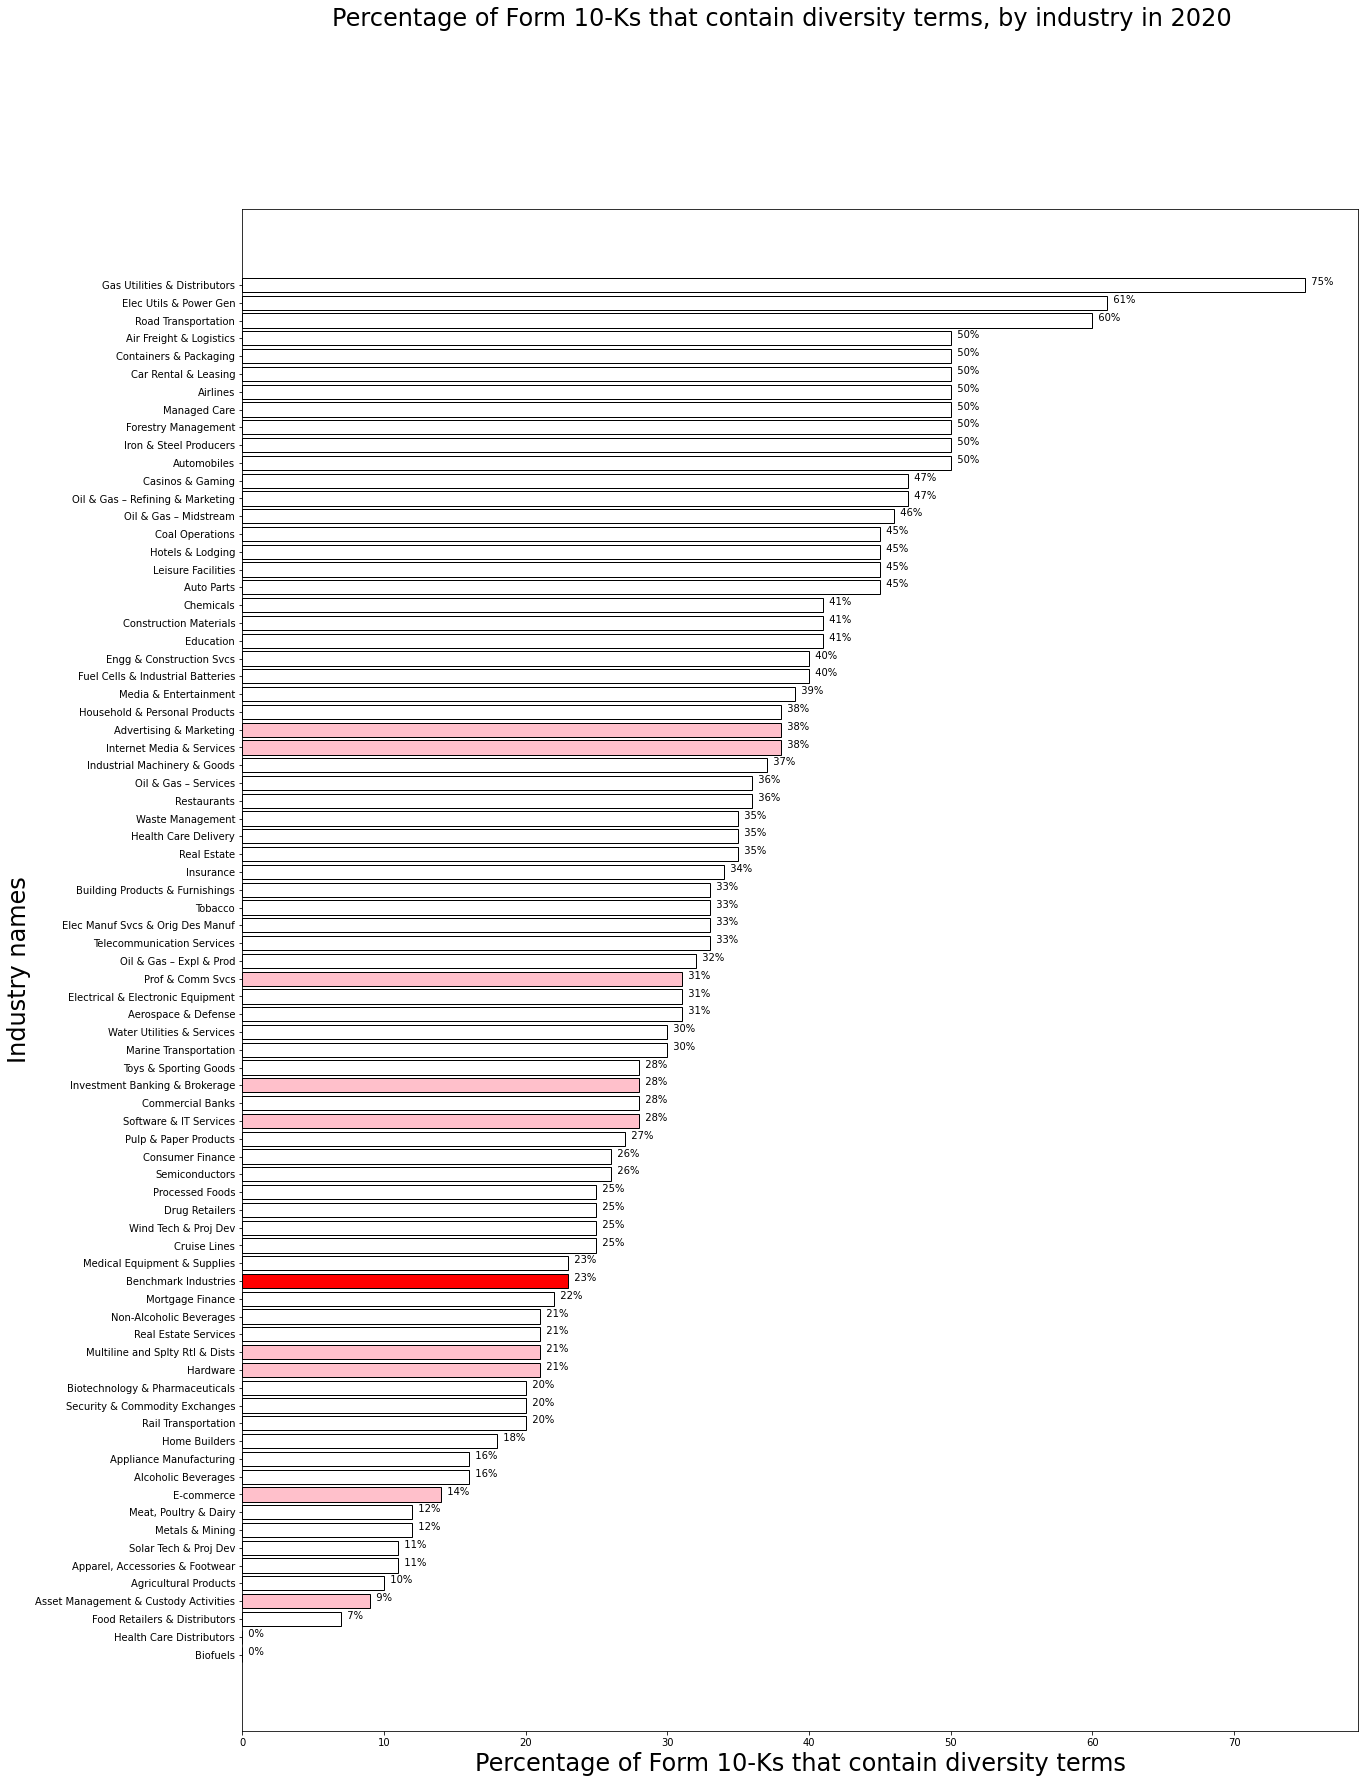

In [ ]:
sub = table_A_dict["2020"][["Industry name","In Benchmark?","Share of 10Ks"]].sort_values(by = ["Share of 10Ks"])
plt.figure(figsize=(20,28))

clrs = []
for x,y in zip(sub["Industry name"], sub["In Benchmark?"]):
	if y == 'Yes':
		if x=='Benchmark Industries':
			clrs.append('red')
   
		else:
			clrs.append('pink')
	else:
		clrs.append('white')  
plt.barh(sub["Industry name"],sub["Share of 10Ks"], color=clrs, edgecolor='black')
for index, value in enumerate(sub["Share of 10Ks"]):
    plt.text(value, index, '  '+str(value)+'%')

plt.suptitle('Percentage of Form 10-Ks that contain diversity terms, by industry in 2020', fontsize=24)
plt.xlabel('Percentage of Form 10-Ks that contain diversity terms', fontsize=24)
plt.ylabel('Industry names', fontsize=24)
plt.savefig('diversity_2020.png')


In [ ]:
# import package
import plotly.graph_objects as go

sector_colors = {'CG': {'fill': 'rgb(127, 60, 141)', 'line': 'rgb(99, 46, 110)'},
                'EM': {'fill': 'rgb(128, 186, 90)', 'line': 'rgb(105, 153, 73)'},
                'FB': {'fill': 'rgb(0, 134, 149)', 'line': 'rgb(1, 110, 122)'},
                'FN': {'fill': 'rgb(207, 28, 144)', 'line': 'rgb(163, 21, 114)'},
                'HC': {'fill': 'rgb(17, 165, 121)', 'line': 'rgb(12, 117, 86)'},
                'IF': {'fill': 'rgb(231, 63, 116)', 'line': 'rgb(184, 48, 91)'},
                'RR': {'fill': 'rgb(230, 131, 16)', 'line': 'rgb(181, 102, 11)'},
                'RT': {'fill': 'rgb(57, 105, 172)', 'line': 'rgb(41, 76, 125)'},
                'SV': {'fill': 'rgb(249, 123, 114)', 'line': 'rgb(199, 97, 90)'},
                'TC': {'fill': 'rgb(242, 183, 1)', 'line': 'rgb(199, 149, 0)'},
                'TR': {'fill': 'rgb(165, 170, 153)', 'line': 'rgb(121, 125, 111)'}
                 }

# set up figure
fig = go.Figure()

# for each sector, add a box trace
for sector_id in df_ht['sector_id'].unique():

    df_tmp = df_ht[(df_ht['sector_id'] == sector_id)]
    df_tmp = df_tmp[~(df_tmp['primary_industry_id'].isin(bm_inds))]

    sector_desc = df_tmp['sector_desc'].unique()[0]

    df_text = df_tmp[['year', 'sector_id', 'sector_desc',
                      'primary_industry_id', 'primary_industry_desc',
                      'bm_ind', 
                      'ind_num_tkr', 'ind_tot_tkr', 'ind_pct_tkr',
                      'bm_pct_tkr']]

    trace = go.Box(y = df_tmp['ind_pct_tkr'],   # plotting the percentage of industries that have the the terms we are interested in, in that para.
                  x = df_tmp['year'], 
                  name = sector_desc, 
                  text = df_text, 
                  marker = dict(color=sector_colors[sector_id]['fill'],
                                line=dict(width=1, 
                                          color=sector_colors[sector_id]['line'])),
                  line = dict(color = 'rgba(0,0,0,0)'),
                  fillcolor = 'rgba(0,0,0,0)',
                  hoveron='points'
                  )
    fig.add_trace(trace)

# for benchmark, add a box trace
df_tmp = df_ht[['year', 'bm_pct_tkr']].drop_duplicates()

trace = go.Box(x=df_tmp['year'], 
               y=df_tmp['bm_pct_tkr'], 
               name='Benchmark',
               marker = dict(color= 'grey', opacity=0),
               line = dict(color = 'lightseagreen', width=3),
               hoverinfo = 'skip',
               hoveron='boxes'
               )
fig.add_trace(trace)

trace = go.Box(x=df_tmp['year'], 
               y=df_tmp['bm_pct_para'], 
               name='Benchmark',
               marker = dict(color= 'grey', opacity=0),
               line = dict(color = 'lightseagreen', width=3),
               hoverinfo = 'skip',
               hoveron='boxes'
               )
fig.add_trace(trace)

# update traces
fig.update_traces(hovertemplate ='Year: %{text[0]}<br>'+
                                #  'Sector ID: %{text[1]}<br>'+
                                 'Sector: %{text[2]}<br>'+
                                #  'Industry ID: %{text[3]}<br>'+
                                 'Industry: %{text[4]}<br>'+
                                 'Benchmark?: %{text[5]}<br>'+
                                 '# of companies with mentions: %{text[6]}<br>'+
                                 'Total # of companies: %{text[7]}<br>'+
                                 'Industry %: %{text[8]:.2%}<br>'+
                                 'Benchmark %: %{text[9]:.2%}<br>',
                 boxpoints = 'all',
                 pointpos = 0,
                 jitter = 1,
                  )

# update layout
### UPDATE ME!!! ###

fig.update_layout(
    title='Proportion of Form 10-K filers with mentions of diversity terms <br>'+\
          '<br>Benchmarks: '+', '.join(bm_inds),
    xaxis_title='Fiscal year',
    yaxis_title='Proportion of companies with mentions',
    template = 'plotly',
    yaxis=dict(tickformat=".0%", range=[-0.01,1.1*df_ht['ind_pct_tkr'].max()]),
)

fig.show()
# upload to plotly
### UPDATE ME!!! ###  To link this in a different site, comment this out
py.plot(fig, filename = 'dfg-cohrv_pct-tkr_'+'-'.join(['430.1']), auto_open=False)

In [ ]:
# df_ht['ind_pct_tkr'].min()
df_ht.columns

Index(['year', 'sector_id', 'sector_desc', 'primary_industry_id',
       'primary_industry_desc', 'ind_tot_tkr', 'ind_num_tkr', 'ind_pct_para',
       'ind_pct_tkr', 'bm_ind', 'bm_pct_tkr', 'bm_pct_para'],
      dtype='object')

In [ ]:
# import package
import plotly.graph_objects as go

sector_colors = {'CG': {'fill': 'rgb(127, 60, 141)', 'line': 'rgb(99, 46, 110)'},
                'EM': {'fill': 'rgb(128, 186, 90)', 'line': 'rgb(105, 153, 73)'},
                'FB': {'fill': 'rgb(0, 134, 149)', 'line': 'rgb(1, 110, 122)'},
                'FN': {'fill': 'rgb(207, 28, 144)', 'line': 'rgb(163, 21, 114)'},
                'HC': {'fill': 'rgb(17, 165, 121)', 'line': 'rgb(12, 117, 86)'},
                'IF': {'fill': 'rgb(231, 63, 116)', 'line': 'rgb(184, 48, 91)'},
                'RR': {'fill': 'rgb(230, 131, 16)', 'line': 'rgb(181, 102, 11)'},
                'RT': {'fill': 'rgb(57, 105, 172)', 'line': 'rgb(41, 76, 125)'},
                'SV': {'fill': 'rgb(249, 123, 114)', 'line': 'rgb(199, 97, 90)'},
                'TC': {'fill': 'rgb(242, 183, 1)', 'line': 'rgb(199, 149, 0)'},
                'TR': {'fill': 'rgb(165, 170, 153)', 'line': 'rgb(121, 125, 111)'}
                 }

# set up figure
fig = go.Figure()

# for each sector, add a box trace
for sector_id in df_ht['sector_id'].unique():
  
    df_tmp = df_ht[(df_ht['sector_id'] == sector_id)]
    df_tmp = df_tmp[~(df_tmp['primary_industry_id'].isin(bm_inds))]

    sector_desc = df_tmp['sector_desc'].unique()[0]

    df_text = df_tmp[['year', 'sector_id', 'sector_desc',
                      'primary_industry_id', 'primary_industry_desc',
                      'bm_ind',
                      'ind_pct_para', 'bm_pct_para']]

    trace = go.Box(y = df_tmp['ind_pct_para'],  # Only different line -> IMP
                  x = df_tmp['year'], 
                  name = sector_desc, 
                  text = df_text, 
                  marker = dict(color=sector_colors[sector_id]['fill'],
                                line=dict(width=1, 
                                          color=sector_colors[sector_id]['line'])),
                  line = dict(color = 'rgba(0,0,0,0)'),
                  fillcolor = 'rgba(0,0,0,0)',
                  hoveron='points'
                  )
    fig.add_trace(trace)

# for benchmark, add a box trace
df_tmp = df_ht[['year', 'bm_pct_para']].drop_duplicates()

trace = go.Box(x=df_tmp['year'], 
               y=df_tmp['bm_pct_para'], 
               name='Benchmark',
               marker = dict(color= 'grey', opacity=0),
               line = dict(color = 'lightseagreen', width=3),
               hoverinfo = 'skip',
               hoveron='boxes'
               )
fig.add_trace(trace)

# update traces
fig.update_traces(hovertemplate ='Year: %{text[0]}<br>'+
                                #  'Sector ID: %{text[1]}<br>'+
                                 'Sector: %{text[2]}<br>'+
                                #  'Industry ID: %{text[3]}<br>'+
                                 'Industry: %{text[4]}<br>'+
                                 'Benchmark?: %{text[5]}<br>'+
                                 'Industry %: %{text[6]:.2%}<br>'+
                                 'Benchmark %: %{text[7]:.2%}<br>',
                 boxpoints = 'all',
                 pointpos = 0,
                 jitter = 1,
                  )

# update layout
### UPDATE ME!!! ###
fig.update_layout(
    title='Average proportion of Form 10-K paragraphs with mentions diversity <br>'+\
          '<br>Benchmarks: '+', '.join(bm_inds),
    xaxis_title='Fiscal year',
    yaxis_title='Average proportion of paragraphs with mentions',
    template = 'plotly',
    yaxis=dict(tickformat=".0%", range=[0, df_ht['ind_pct_para'].max()]),
)

# print(LIST_OF_HEURISTICS)
fig.show()

# upload to plotly
# ### UPDATE ME!!! ###
# py.plot(fig, filename = 'dfg-cohrv_avg-pct-para_'+'-'.join(['430.1']), auto_open=False)

In [ ]:
fig = go.Figure()

for year in df_ht['year'].unique():

  df_tmp = df_ht[df_ht['year'] == year]

  trace = go.Box(y = df_tmp['ind_pct_tkr'], 
                 x = df_tmp['year'], 
                #  name = sector_id, 
                 text = df_text,
                 showlegend=False,
                 line = dict(color = 'rgb(141,160,203)'),
                #  fillcolor = 'lightgray',
                 boxpoints = 'outliers',
                #  boxmean = 'sd',
                 )
  
  fig.add_trace(trace)

for sector in df_ht['sector_id'].unique():
  

  df_tmp = df_ht[df_ht['sector_id'] == sector]
  # df_tmp = df_tmp[~(df_tmp['primary_industry_id'].isin(bm_inds))]

  df_text = df_tmp[['year', 'primary_industry_id', 'primary_industry_desc', 
                    'ind_num_tkr', 'ind_tot_tkr', 'ind_pct_tkr']]

  trace = go.Box(y = df_tmp['ind_pct_tkr'], # IMP
                 x = df_tmp['year'], 
                 name = sector, 
                 text = df_text,
                 marker = dict(color=sector_colors[sector]['fill'],
                                line=dict(
                                          color=sector_colors[sector]['line'])),
                 showlegend=True,
                 line = dict(color = 'rgba(0,0,0,0)'),
                 fillcolor = 'rgba(0,0,0,0)',
                 hovertemplate ='Year: %{text[0]}<br>'+
                                 'Industry ID: %{text[1]}<br>'+
                                 'Industry: %{text[2]}<br>'+
                                 '# of companies with mentions: %{text[3]}<br>'+
                                 'Total # companies in industry: %{text[4]}<br>'+
                                 '% of companies with mentions: %{text[5]:.2%}<br>',
                 boxpoints = 'all',
                #  pointpos = -1,
                 jitter = 1
                 )
  
  fig.add_trace(trace)

# fig.update_traces()

fig.update_layout(
    title='GIC 430: Supply Chain Management<br>'+
          'Percentage of companies in an industry that mentioned the following in their supply chains <br>',\
    xaxis_title='Fiscal year',
    yaxis_title='Percentage of companies ',
    template = 'plotly',
    yaxis=dict(tickformat=".0%"),
    boxgap = 0.25,
    boxgroupgap = 0.5
)

fig.show()
# py.plot(fig, filename = 'dfg-cohrv-pct-tkr-box'+'-'.join(['430.1']), auto_open=False)

In [ ]:

df_result[(df_result['primary_industry_id']=='TC-ES')&(df_result['year']=='2017')].iloc[:,:7]

,gic_heuristic_id,id,ticker_display,primary_industry_id,text,yr_qtr,ticker


In [ ]:
df_result[(df_result['primary_industry_id']=='SV-HL')&(df_result['year']=='2020')].iloc[:,:7] # going through paras

,gic_heuristic_id,id,ticker_display,primary_industry_id,text,yr_qtr,ticker
39,330.2,2021Q1_HGV_10-K_20201231_0001564590-21-009825.txt_52,HGV,SV-HL,For more than 25 years we have created and delivered vacation experiences for guests from around the world. Our people first talent strategy is inclusive of programs and services which are designed to ensure that our employees feel engaged appreciated and rewarded for their contributions. We focus on hiring practices that are reflective of our values and seek customer-centric individuals that embody a spirit of service towards our owners guests and fellow team members. We believe hiring people with different backgrounds cultures and perspectives leads to increased creativity and innovation. We are committed to connecting with and engaging talent from diverse backgrounds to ensure our team member population is reflective of the communities in which we live and work. Using a multi-channel approach we grow our HGV talent network through a variety of outreach programs that include targeted media team member referrals and diversity outreach. As of December 31 2020 more than 6700 including furloughed team members were employed at our timeshare resorts call centers and corporate locations around the world.,2021Q1,HGV
40,330.2,2021Q1_HGV_10-K_20201231_0001564590-21-009825.txt_55,HGV,SV-HL,We are committed to an inclusive workforce that fully represents many different cultures backgrounds and viewpoints. Our Team Member Resource Groups (TMRGs) which are voluntary employee-led groups play an integral part in our culture of inclusion as we strive to foster openness integrity and respect. We currently have six TMRG's: African American Asia Pacific Islander Hispanic Latino LGBTQ & Friends Military and Women's. Each group is sponsored by a senior executive who provides leadership and helps drives initiatives across the business. In addition we believe that multiple perspectives generate better solutions and relatability with our diverse base of customers and consumers. We strike to ensure a common inclusion that we believe is reflected in our programs and initiatives and we regularly seek team member feedback through our annual engagement survey and ongoing discussions with our TMRG's.,2021Q1,HGV
41,330.2,2021Q1_HGV_10-K_20201231_0001564590-21-009825.txt_56,HGV,SV-HL,Through a variety of delivery methods we offer over 1000 training and development courses to all of our team members focused on variety of core competencies including: leadership diversity and inclusion skills training business acumen culture and personal growth. In 2020 team members completed approximately 65000 hours total training hours with over 8200 hours specifically dedicated to compliance training.,2021Q1,HGV
42,330.2,2021Q1_HLT_10-K_20201231_0001585689-21-000016.txt_63,HLT,SV-HL,"We are committed to an inclusive workforce that fully represents many different cultures backgrounds and viewpoints. Our President and Chief Executive Officer chairs the Hilton Executive Inclusion Council which comprises the Company's most senior leaders and provides oversight of our diversity and inclusion programs and initiatives. Additionally each of our eight Team Member Resource Groups (""TMRG"") is sponsored by an executive committee leader. These groups provide members with opportunities for career development and the chance to share their unique perspectives and viewpoints with leadership and other colleagues. We also leverage our TMRGs to provide insights for our business. With over 50 chapters across the world our TMRGs utilize virtual programming so that even during the pandemic we are continuing to stay connected and drive important conversations about inclusion and equity across the enterprise.",2021Q1,HLT
43,330.2,2021Q1_HLT_10-K_20201231_0001585689-21-000016.txt_64,HLT,SV-HL,We require all employees to complete training as part of our Inclusive and Respectful Workplace curriculum which is based on the underlying principles of our Code

In [ ]:
# THIS CODE CELL DOES NOT CONSIDER MEDIANS.
# AGGREGATION OF # OF TICKERS AND # OF PARAGRAPHS ARE DONE AT THE INDUSTRY
# AND BENCHMARK GROUP LEVELS.

# make a copy of the result df
df_ht = df_result.copy()

### COMPANY LEVEL ###
# aggregate metrics from the paragraph level to the company level
df_ht = df_ht.groupby(['gic_heuristic_id', 'year', 'ticker_display', 
                       'sector_id', 'sector_desc', 
                       'primary_industry_id', 'primary_industry_desc', 
                       'tkr_tot_para', 'ind_tot_tkr',
                      #  'sec_tot_tkr'
                       ])\
                        .agg({'result': 'sum'})\
                        .reset_index()\
                        .sort_values(by=['year', 'primary_industry_id', 'ticker_display'])

df_ht = df_ht.rename(columns={'result': 'tkr_num_para'})
df_ht['tkr_pct_para'] = df_ht['tkr_num_para']/df_ht['tkr_tot_para']
df_ht['tkr_num_tkr'] = df_ht['tkr_num_para'].apply(lambda x: 1 if x > 0 else 0)

### INDUSTRY LEVEL ###
# aggregate metrics from the company level to the industry level

df_ht = df_ht.groupby(['gic_heuristic_id', 'year', 
                               'sector_id', 'sector_desc', 
                               'primary_industry_id', 'primary_industry_desc', 
                               'ind_tot_tkr'])\
                               .agg({'tkr_num_tkr': 'sum',
                                     'tkr_num_para': 'sum',
                                     'tkr_tot_para': 'sum'})\
                               .reset_index()
df_ht = df_ht.rename(columns={'tkr_num_tkr': 'ind_num_tkr',
                              'tkr_num_para': 'ind_num_para',
                              'tkr_tot_para': 'ind_tot_para'})

# compute the % of relevant paragraphs
df_ht['ind_pct_para'] = df_ht['ind_num_para']/df_ht['ind_tot_para']

# compute the % of companies with at least 1 mention of GIC topic
df_ht['ind_pct_tkr'] = df_ht['ind_num_tkr']/df_ht['ind_tot_tkr']
df_ht

### INDUSTRY LEVEL (NON-BENCHMARK) ###
# set up dataframe for non-benchmarked industries
# df_ht_nbm = df_ht[~df_ht['primary_industry_id'].isin(bm_inds)]
df_ht_nbm = df_ht
df_ht_nbm

### INDUSTRY LEVEL (BENCHMARK) ###
# set up dataframe for benchmarked industries
df_ht_bm = df_ht[df_ht['primary_industry_id'].isin(bm_inds)]
df_ht_bm

# look for the overall % of companies with mentions among benchmarked industries
df_ht_bm = df_ht_bm.groupby(['year']).agg({'ind_tot_tkr': 'sum',
                                                   'ind_num_tkr': 'sum',
                                                   'ind_tot_para': 'sum',
                                                   'ind_num_para': 'sum'})\
                                             .reset_index()
df_ht_bm = df_ht_bm.rename(columns={'ind_tot_tkr': 'bm_tot_tkr',
                                                    'ind_num_tkr': 'bm_num_tkr',
                                                    'ind_tot_para': 'bm_tot_para',
                                                    'ind_num_para': 'bm_num_para'})
df_ht_bm['bm_pct_tkr'] = df_ht_bm['bm_num_tkr']/df_ht_bm['bm_tot_tkr']                                  
df_ht_bm['bm_pct_para'] = df_ht_bm['bm_num_para']/df_ht_bm['bm_tot_para']                                  

df_ht_bm = df_ht_bm[['year',
                     'bm_num_tkr', 'bm_tot_tkr', 'bm_pct_tkr',
                     'bm_num_para', 'bm_tot_para', 'bm_pct_para']]
df_ht_bm

### INDUSTRY LEVEL - READY FOR HYPOTHESIS TESTING ###
# merge benchmark metric to non-benchmark metrics
df_ht = pd.merge(left=df_ht_nbm, right=df_ht_bm, on='year')
# df_ht = df_ht_nbm

df_ht.head(3)

,gic_heuristic_id,year,sector_id,sector_desc,primary_industry_id,primary_industry_desc,ind_tot_tkr,ind_num_tkr,ind_num_para,ind_tot_para,ind_pct_para,ind_pct_tkr,bm_num_tkr,bm_tot_tkr,bm_pct_tkr,bm_num_para,bm_tot_para,bm_pct_para
0,330.2,2013,CG,Consumer Goods,CG-AA,"Apparel, Accessories & Footwear",78,2,2,638,0.0%,0.0%,17,581,0.0%,33,5634,0.0%
1,330.2,2013,CG,Consumer Goods,CG-HP,Household & Personal Products,27,3,6,1679,0.0%,0.1%,17,581,0.0%,33,5634,0.0%
2,330.2,2013,CG,Consumer Goods,CG-MR,Multiline and Splty Rtl & Dists,86,2,2,453,0.0%,0.0%,17,581,0.0%,33,5634,0.0%
